In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma

embedding_function = OpenAIEmbeddings()

docs = [
    Document(
        page_content="Bella Vista is owned by Antonio Rossi, a renowned chef with over 20 years of experience in the culinary industry. He started Bella Vista to bring authentic Italian flavors to the community.",
        metadata={"source": "owner.txt"},
    ),
    Document(
        page_content="Bella Vista offers a range of dishes with prices that cater to various budgets. Appetizers start at $8, main courses range from $15 to $35, and desserts are priced between $6 and $12.",
        metadata={"source": "dishes.txt"},
    ),
    Document(
        page_content="Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.",
        metadata={"source": "restaurant_info.txt"},
    ),
    Document(
        page_content="Bella Vista offers a variety of menus including a lunch menu, dinner menu, and a special weekend brunch menu. The lunch menu features light Italian fare, the dinner menu offers a more extensive selection of traditional and contemporary dishes, and the brunch menu includes both classic breakfast items and Italian specialties.",
        metadata={"source": "restaurant_info.txt"},
    ),
]

db = Chroma.from_documents(docs, embedding_function)
# retriever = db.as_retriever()
retriever = db.as_retriever(search_kwargs={"k": 2})

In [3]:
from langchain_core.prompts import ChatPromptTemplate

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [4]:
llm = ChatOpenAI(model="gpt-4o-mini")
rag_chain = prompt | llm

In [5]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain.schema import Document
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage

class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )

def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state['documents'] = []
    state['on_topic'] = ''
    state['rephrased_question'] = ''
    state['proceed_to_generate'] = False
    state['rephrase_count'] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval.")
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = ChatOpenAI(model="gpt-4o-mini")
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(content="""You are a classifier that determines whether a user's question is about one of the following topics:

1. Information about the owner of Bella Vista, which is Antonio Rossi.
2. Prices of dishes at Bella Vista (restaurant).
3. Opening hours of Bella Vista (restaurant).

If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.""")

    human_message = HumanMessage(content=f"User question: {state['rephrased_question']}")
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"

def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state

class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'.""")

    llm = ChatOpenAI(model="gpt-4o-mini")
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}")
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}")
        if result.score.strip().lower() == 'yes':
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "cannot_answer"
    else:
        print("Routing to refine_question")
        return "refine_question"

def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(content="""You are a helpful assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question.""")
    human_message = HumanMessage(content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question.")
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = ChatOpenAI(model="gpt-4o-mini")
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke({"history": history, "context": documents, "question": rephrased_question})

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

def cannot_answer(state: AgentState):
    print("Entering cannot_answer")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I'm sorry, but I cannot find the information you're looking for."))
    return state

def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    state["messages"].append(AIMessage(content="I can't respond to that!"))
    return state

In [6]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

In [7]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
workflow.add_node("cannot_answer", cannot_answer)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "cannot_answer": "cannot_answer",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
workflow.add_edge("cannot_answer", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

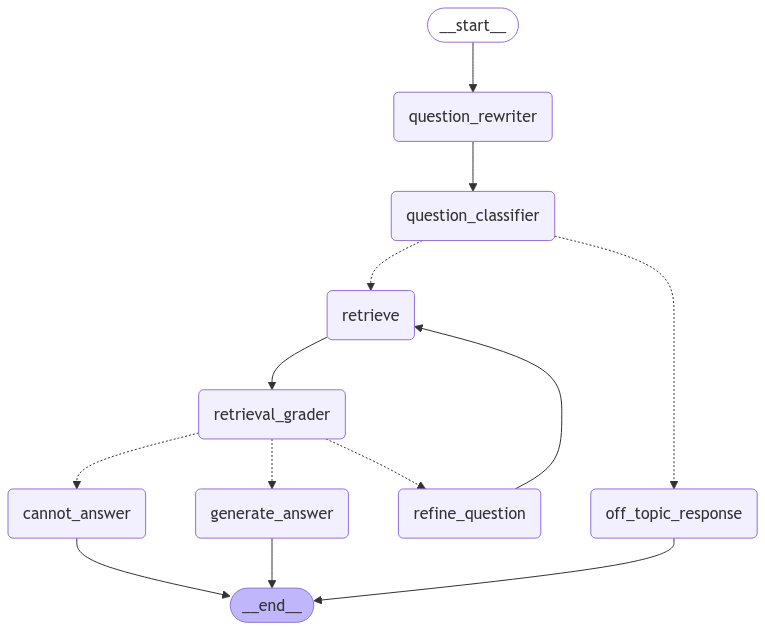

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Off topic

In [9]:
input_data = {"question": HumanMessage(content="How is the weather?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response


{'messages': [HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I can't respond to that!", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'How is the weather?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='How is the weather?', additional_kwargs={}, response_metadata={})}

### No docs found

In [10]:
input_data = {"question": HumanMessage(content="How old is the owner of the restaurant Bella Vista?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter with following state: {'question': HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 2 documents
Entering retrieval_grader
Grading document: Bella Vista is owned by Antoni... Result: No
Grading document: Bella Vista is open from Monda... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_question
Entering refine_question
refine_question: Refined question: What is the age of the owner of Bella Vista restaurant?
Entering retrieve
retrieve: Retrieved 2 documents
Entering retrieval_grader
Grading document: Bella Vista is owned by Antoni... Result: No
Grading document: Bella Vista is open from Monda... Result: No
retrieval_grader: proceed_to_generate = False
Entering proceed_router
Routing to refine_qu

{'messages': [HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'Yes',
 'rephrased_question': 'What is the age of the owner of the Bella Vista restaurant?',
 'proceed_to_generate': False,
 'rephrase_count': 2,
 'question': HumanMessage(content='How old is the owner of the restaurant Bella Vista?', additional_kwargs={}, response_metadata={})}

### Rag with History

In [11]:
input_data = {"question": HumanMessage(content="When does the Bella Vista restaurant open?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 2 documents
Entering retrieval_grader
Grading document: Bella Vista is open from Monda... Result: Yes
Grading document: Bella Vista offers a variety o... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: The Bella Vista restaurant opens from 11:00 AM. Weekday hours are from 11:00 AM to 10:00 PM, and on weekends, it is open from 11:00 AM to 11:00 PM.


{'messages': [HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The Bella Vista restaurant opens from 11:00 AM. Weekday hours are from 11:00 AM to 10:00 PM, and on weekends, it is open from 11:00 AM to 11:00 PM.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.')],
 'on_topic': 'Yes',
 'rephrased_question': 'When does the Bella Vista restaurant open?',
 'proceed_to_generate': True,
 'rephrase_count': 0,
 'question': HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={})}

In [12]:
input_data = {"question": HumanMessage(content="Also on sunday?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={}), AIMessage(content='The Bella Vista restaurant opens from 11:00 AM. Weekday hours are from 11:00 AM to 10:00 PM, and on weekends, it is open from 11:00 AM to 11:00 PM.', additional_kwargs={}, response_metadata={})], 'documents': [Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.')], 'on_topic': 'Yes', 'rephrased_question': 'When does the Bella Vista restaurant open?', 'proceed_to_generate': True, 'rephrase_count': 0, 'question': HumanMessage(content='Also on sunday?', additional_kwargs={}, response_metadata={})}
question_rewriter: Rephrased question: What are the opening hours of the Bella Vista restaurant on Sundays?
Entering question_classifier
question_cl

{'messages': [HumanMessage(content='When does the Bella Vista restaurant open?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The Bella Vista restaurant opens from 11:00 AM. Weekday hours are from 11:00 AM to 10:00 PM, and on weekends, it is open from 11:00 AM to 11:00 PM.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Also on sunday?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='The Bella Vista restaurant is open on Sundays from 11:00 AM to 11:00 PM.', additional_kwargs={}, response_metadata={})],
 'documents': [Document(metadata={'source': 'restaurant_info.txt'}, page_content='Bella Vista is open from Monday to Sunday. Weekday hours are 11:00 AM to 10:00 PM, while weekend hours are extended from 11:00 AM to 11:00 PM.')],
 'on_topic': 'Yes',
 'rephrased_question': 'What are the opening hours of the Bella Vista restaurant on Sundays?',
 'proceed_to_generate': True,
 'rephrase_count': 0,
 'question': HumanMessage(content